In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime as dt

import pickle 

def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [2]:
input_folder        = '../output_files/processed_data'
output_parameters   = '../output_files/fitted_parameters'
output_fitted       = '../output_files/fitted_data'

In [3]:
data_folder             = '../data'
geo_colombia_info_file  = 'geoinfo_municipios_colombia.csv'

In [4]:
df_mun_info = pd.read_csv(f'{data_folder}/{geo_colombia_info_file}')[['COD_DEPTO','NOM_DEPART']].drop_duplicates()

In [5]:
traj_1 = ['SATA FE DE BOGOTÁ D.C.', 'TOLIMA', 'HUILA', 'CAUCA', 'NARIÑO',  'PUTUMAYO', 'META', 'CAQUETÁ', 'GUAVIARE', 'VICHADA', 'GUAINIA', 'VAUPES', 'AMAZONAS']
traj_2 = ['ANTIOQUIA', 'VALLE DEL CAUCA', 'QUINDIO',  'CALDAS', 'RISARALDA']
traj_3 = ['SATA FE DE BOGOTÁ D.C.', 'CUNDINAMARCA', 'BOYACÁ', 'CASANARE', 'ARAUCA']
traj_4 = ['ANTIOQUIA', 'CHOCÓ', 'CÓRDOBA', 'SUCRE', 'BOLÍVAR']
traj_5 = ['SANTANDER', 'NORTE DE SANTANDER', 'CESAR', 'MAGDALENA', 'ATLANTICO', 'LA GUAJIRA']
traj_6 = ['BOLÍVAR', 'ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA']

trajectories = [traj_1, traj_2, traj_3, traj_4, traj_5, traj_6]
#trajectories = [traj_3]

In [6]:
def model_func(x, rho, a, b, c, d):
    return rho * (1 / (1 + np.exp(-(a * x / 500) - b))) * (1 - (1 / (1 + np.exp(-(c * x / 500) - d))))

class ModelFunc(torch.nn.Module):
    def __init__(self, rho0: float, a0: float, b0: float, c0: float, d0: float):
        super(ModelFunc, self).__init__()    
        self.rho = torch.nn.Parameter(torch.tensor(rho0, dtype=torch.float32))
        self.a = torch.nn.Parameter(torch.tensor(a0, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b0, dtype=torch.float32))
        self.c = torch.nn.Parameter(torch.tensor(c0, dtype=torch.float32))
        self.d = torch.nn.Parameter(torch.tensor(d0, dtype=torch.float32))
    
    def forward(self, x):
        return self.rho * (1 / (1 + torch.exp(-(self.a * x / 500) - self.b))) * (1 - (1 / (1 + torch.exp(-(self.c * x / 500) - self.d))))

# Define the loss function
loss_function = torch.nn.MSELoss()


In [7]:
for traj in trajectories: 
    print(traj)
    initial_department_code = df_mun_info[df_mun_info.NOM_DEPART == traj[0]].COD_DEPTO.iloc[0]
    initial_department_name = traj[0]
    for n_, departament in enumerate(traj[1:]):
        with open(f'{output_parameters}/{initial_department_code}_fit_params.obj', 'rb') as inp:
            initial_point_variant_fit = pickle.load(inp)

        target_department_code = df_mun_info[df_mun_info.NOM_DEPART == departament].COD_DEPTO.iloc[0]
        print(f'{initial_department_name}_{initial_department_code}', f'{departament}_{target_department_code}')

        ##########################################################################3
        df = pd.read_csv(f'{input_folder}/{target_department_code}_dominance_data.csv').replace(['0', 0], np.nan)
        df['start_date'] = '2020-01-01'
        df['date'] = pd.to_datetime(df['date'])
        df['start_date'] = pd.to_datetime(df['start_date'])
        df['days'] = (df['date'] - df['start_date']) / np.timedelta64(1, 'D')

        variant_list = np.setdiff1d(df.columns.to_numpy() ,['date', 'week', 'start_date', 'days'])
        missing_variants = np.setdiff1d(['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros'], variant_list)
        print(variant_list, missing_variants)
        ##########################################################################
        if 'Alpha' in variant_list:
            mask = df['Alpha'] > 0.5
            df.loc[mask, 'Alpha'] = 0

        ##########################################################################
        ##########################################################################
        # Gradient descent loop
        variant_fits = {}
        max_iterations = 1000
        #for variant in ['Alpha']:
        for variant in variant_list:
            df_ = df[~df[variant].isna()].copy()
            x_tensor = torch.tensor(df_['days'].values, dtype=torch.float32)
            y_tensor = torch.tensor(df_[variant].values, dtype=torch.float32)

            # Initialize your model
            model = ModelFunc(1, *tuple(initial_point_variant_fit[variant]))
            optimizer = torch.optim.SGD(model.parameters(), lr=(1+3*n_)*0.005)

            for _ in range(max_iterations):
                optimizer.zero_grad()  # Clear gradients from the previous step
                y_pred = model(x_tensor)  # Compute model predictions
                loss = loss_function(y_pred, y_tensor)  # Compute the loss
                loss.backward()  # Compute gradients
                optimizer.step()  # Update parameters
            
            # Store the optimized parameters for the variant
            variant_fits[variant] = [model.a.item(), model.b.item(), model.c.item(), model.d.item()]

        for variant in missing_variants:
            variant_fits[variant] = [initial_point_variant_fit[variant][0], 
                                     initial_point_variant_fit[variant][1],
                                     initial_point_variant_fit[variant][2],
                                     initial_point_variant_fit[variant][3]]

        # sample usage
        save_object(variant_fits, f'{output_parameters}/{target_department_code}_fit_params.obj')

        initial_department_code = target_department_code
        initial_department_name = departament

['SATA FE DE BOGOTÁ D.C.', 'TOLIMA', 'HUILA', 'CAUCA', 'NARIÑO', 'PUTUMAYO', 'META', 'CAQUETÁ', 'GUAVIARE', 'VICHADA', 'GUAINIA', 'VAUPES', 'AMAZONAS']
SATA FE DE BOGOTÁ D.C._11 TOLIMA_73
['Alpha' 'Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] []


TOLIMA_73 HUILA_41
['Alpha' 'Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] []
HUILA_41 CAUCA_19
['Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] ['Alpha']
CAUCA_19 NARIÑO_52
['Alpha' 'Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] []
NARIÑO_52 PUTUMAYO_86
['Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] ['Alpha']
PUTUMAYO_86 META_50
['Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] ['Alpha']
META_50 CAQUETÁ_18
['Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] ['Alpha']
CAQUETÁ_18 GUAVIARE_95
['Gamma' 'Mu' 'Otros'] ['Alpha' 'Delta' 'Omicron']
GUAVIARE_95 VICHADA_99
['Mu' 'Otros'] ['Alpha' 'Delta' 'Gamma' 'Omicron']
VICHADA_99 GUAINIA_94
['Delta' 'Gamma' 'Mu' 'Otros'] ['Alpha' 'Omicron']
GUAINIA_94 VAUPES_97
['Delta' 'Mu' 'Otros'] ['Alpha' 'Gamma' 'Omicron']
VAUPES_97 AMAZONAS_91
['Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] ['Alpha']
['ANTIOQUIA', 'VALLE DEL CAUCA', 'QUINDIO', 'CALDAS', 'RISARALDA']
ANTIOQUIA_5 VALLE DEL CAUCA_76
['Alpha' 'Delta' 'Gamma' 'Mu' 'Omicron' 'Otros'] []
VALLE DEL CAUCA_76 QUINDIO_63
['Alpha' 'Delta' 'Gamma' 'Mu'

In [8]:
start_date  = '2020-01-01'
end_date    = '2023-12-31'

In [9]:
dept_list = df_mun_info.COD_DEPTO.sort_values()[:-1]
for target_department_code in dept_list:
    df_fitted = pd.DataFrame({})
    df_fitted['date']        = pd.date_range(start=start_date, end=end_date, freq='W')
    df_fitted['start_date']  = pd.to_datetime(start_date)
    df_fitted['days']        = (df_fitted['date'] - df_fitted['start_date']) / np.timedelta64(1, 'D')

    with open(f'{output_parameters}/{target_department_code}_fit_params.obj', 'rb') as inp:
        variant_fits = pickle.load(inp)

    ## get normalization
    normalization = np.zeros(len(df_fitted['days']))
    for var in ['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros']:
        normalization += model_func(df_fitted['days'], 1, *tuple(variant_fits[var]))

    for var in ['Alpha', 'Gamma', 'Mu', 'Delta', 'Omicron', 'Otros']:
        y_1 = model_func(df_fitted['days'], 1, *tuple(variant_fits[var])) / normalization
        df_fitted[var] = y_1

    df_fitted.to_csv(f'{output_fitted}/{target_department_code}_dominance_data.csv', index=False)

# Test

In [10]:
# Assign a color to each variant for plotting
variant_colors = {
    'Alpha': 'blue',
    'Gamma': 'orange',
    'Mu'    :'red',
    'Delta': 'purple',
    'Omicron': 'magenta',
    'Otros' : 'black'
}

In [11]:
target_department_code = 68

# Load the DataFrame
df = pd.read_csv(f'{input_folder}/{target_department_code}_dominance_data.csv').replace(['0', 0], np.nan)
df['date'] = pd.to_datetime(df['date'])

df_fitted = pd.read_csv(f'{output_fitted}/{target_department_code}_dominance_data.csv')
df_fitted['date'] = pd.to_datetime(df_fitted['date'])

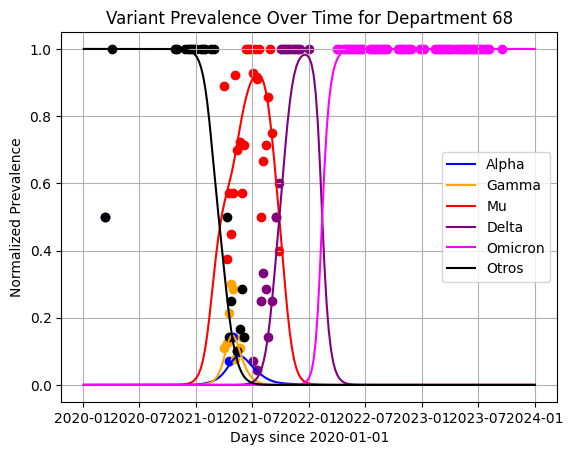

In [12]:
for var in variant_colors.keys():
    plt.plot(df_fitted['date'] , df_fitted[var], color=variant_colors[var], label=var)

    # Scatter plot for observed data points
    if var in df:
        plt.scatter(df['date'] , df[var], color=variant_colors[var])
    
plt.legend()  # Show legend to identify variants
plt.xlabel('Days since 2020-01-01')
plt.ylabel('Normalized Prevalence')
plt.title(f'Variant Prevalence Over Time for Department {target_department_code}')
plt.grid()